Deep Learning - Final Exam

NIM : 2440016804

Nama : Rio Pramana

Kelas : LA01

# Nomor 2a, 2b, 2c, dan 2d

# 2a. Preprocess & prepare dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

## Reading and looking at the dataset

In [2]:
# Importing the dataset, downloaded file is in the same folder
csv_path = "./clickbait.csv"
clickbait_df = pd.read_csv(csv_path)

In [3]:
clickbait_df.head(5)

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [4]:
clickbait_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [5]:
clickbait_df.isnull().sum()

headline     0
clickbait    0
dtype: int64

In [6]:
#Set style ggplot
style.use('ggplot')

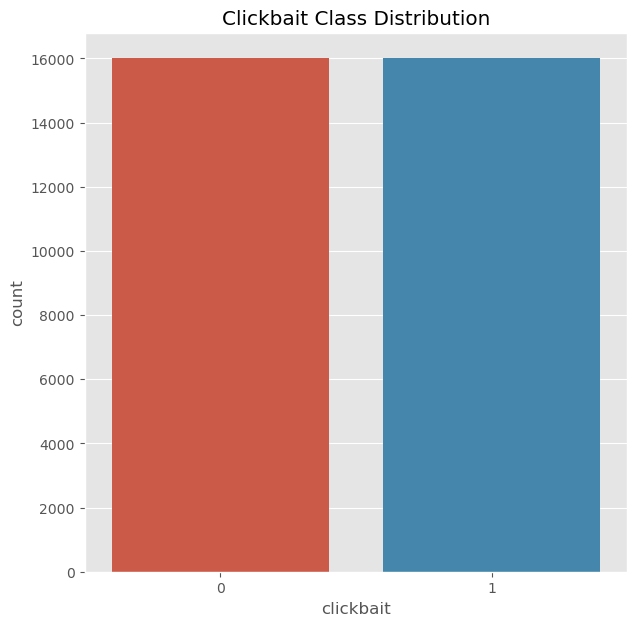

In [7]:
plt.figure(figsize=(7,7))
sns.countplot(x='clickbait', data=clickbait_df)
plt.title('Clickbait Class Distribution')
plt.show()

In [8]:
# Cek apakah ada row yang headlinenya duplicate
print("Number of duplicate data/headline: {}".format(clickbait_df.duplicated(subset=["headline"]).sum()))

Number of duplicate data/headline: 0


Setelah dilakukan beberapa pengecekan seperti diatas, terlihat bahwa dataset ini memiliki 32000 data dengan 50% class 1 dan 50% class 0. Tidak ada data yang kosong/duplikat

## Preprocess dataset

Terdapat beberapa hal yang saya lakukan terhadap dataset ini:
1. Merubah semua huruf menjadi lowercase
2. Menghapus tanda baca
3. Menghapus text yang berupa angka
4. Menghapus character \r dan \n
5. Menghapus stopwords dalam bahasa Inggris
6. Melakukan lemmatization
7. Melakukan tokenization
8. Melakukan padding untuk menyesuaikan input dengan model
9. Menghapus spasi yang berlebihan

1. Seluruh string yang ada pada kolom headline perlu diubah menjadi lowercase agar dimensionalitas pada data berkurang dan semua kata yang sama akan dianggap sama walaupun penggunaan huruf kapitalnya berbeda (misalnya kata 'learning', 'Learning', dan 'LeaRnIng' akan dianggap sebagai kata yang sama)

2. Menghapus tanda baca pada text juga merupakan step yang penting karena tanda-tanda baca tidak memiliki makna semantik yang signifikan untuk menentukan apakah sebuah headline merupakan clickbait atau tidak. Tidak hanya tanda baca ini tidak membawa hal positif, tanda baca ini justru bisa berdampak negatif karena akan memengaruhi bagaimana model belajar mengklasifikasi headline mana yang merupakan clickbait berdasarkan kata yang digunakan

3. Menghapus angka juga merupakan step yang penting seperti step nomor 2. Angka pada headline tidak mengandung makna yang signifikan

4. Menghapus \r dan \n juga membantu data text menjadi lebih bersih (menghilangkan characters yang tidak terlalu bermakna)

5. Menghapus stopwords juga menjadi step yang penting karena biasanya dalam bahasa Inggris terdapat beberapa kata yang hampir selalu digunakan dalam setiap kalimat (seperti "the" dan "and") sehingga kata-kata tersebut tidak membawa makna apa-apa dalam menentukan clickbait

6. Lemmatization membantu mengurangi dimensionalitas data dan membantu model dalam memahami konteks dari sebuah kata dengan lebih baik. Lemmatization berfungsi dengan cara merubah sebuah kata ke base formnya (misalnya 'studied' menjadi 'study') tanpa menghilangkan makna dari katanya (berbeda dengan stemming yang akan merubah kata 'studied' menjadi 'studi' yang bukan merupakan kata dalam bahasa Inggris)

7. Tokenization berguna untuk model yang akan di-train dengan cara merubah setiap kata pada text menjadi integer-integer yang unik sehingga sebuah text bisa direpresentasikan sebagai sequence yang akan digunakan sebagai input model

8. Padding dilakukan agar setiap text memiliki shape yang sama karena model akan mengharapkan input dengan shape tertentu (tidak bervariasi). Padding dilakukan dengan menambahkan 0 pada sequence text sampai semua sequence memiliki length yang sama

9. Penghapusan space di akhir preprocessing sangat berguna untuk menghapus karakter spasi yang berlebihan, terutama akibat step preprocessing yang dilakukan sebelumnya

In [9]:
def remove_unnecessary_spaces(string):
    string = string.strip() # remove spaces di depan dan belakang string
    string = " ".join(string.split()) # remove unnecessary spaces antar kata di string
    return string

In [10]:
import string as st
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text_before_tokenize(original_df, column):
    # copy the dataframe so we do not change the original dataframe
    df = original_df.copy()
    # turn all text to lowercase
    df[column] = df[column].str.lower() # convert to lowercase
    # remove punctuations
    df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '', x))
    # remove numbers
    df[column] = df[column].str.replace('\d+','') # remove numbers
    # remove \r & \n
    df[column] = df[column].str.replace('\r', '')
    df[column] = df[column].str.replace('\n', '')
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    df[column] = df[column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
    # remove all unnecessary/extra spaces
    df[column] = df[column].apply(remove_unnecessary_spaces)
    
    return df

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(token) for token in tokens]

def apply_lemmatization(data):
    data = [lemmatize_text(text) for text in data.tolist()]
    
    return data

def tokenize_data_for_LSTM(X_train, X_val, X_test, vocab_size, maxlen):
    X_train = apply_lemmatization(X_train)
    X_val = apply_lemmatization(X_val)
    X_test = apply_lemmatization(X_test)
    texts = X_train + X_val + X_test
    tokenizer = Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(texts)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_val = tokenizer.texts_to_sequences(X_val)
    X_test = tokenizer.texts_to_sequences(X_test)
    # Pad the sequences to make all of them the same length
    X_train = pad_sequences(X_train, maxlen = maxlen)
    X_val = pad_sequences(X_val, maxlen = maxlen)
    X_test = pad_sequences(X_test, maxlen = maxlen)
    
    return X_train, X_val, X_test

Functions dibawah ini adalah helper functions yang membantu untuk menentukan nilai vocab_size dan maxlen. Vocab_size baiknya memiliki value sebanyak jumlah kata yang unik pada dataset, sedangkan maxlen baiknya memilki value sebanyak panjang text terpanjang pada dataset

In [11]:
def get_num_unique_words(df, column):
    all_words = []
    for words in df[column].values:
        all_words.extend(words)
    unique_words = set(all_words)
    
    return len(unique_words)

def get_len_longest_string(df, column):
    return len(max(df[column], key=len))

In [12]:
def preprocess_dataset_LSTM(original_df, column):
    df = original_df.copy()
    df = clean_text_before_tokenize(df, column)

    return df

Preprocess dataframe (sebelum tokenization)

In [13]:
cleaned_clickbait_df = preprocess_dataset_LSTM(clickbait_df, 'headline')
cleaned_clickbait_df.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_6104\2926137536.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\d+','') # remove numbers


,headline,clickbait
0,get bings,1
1,tv female friend group belong,1
2,new star wars force awakens trailer give chills,1
3,vine new york celebrity big brother fucking pe...,1
4,couple stunning photo shoot baby learning inop...,1


## Split dataset

Dataset saya split menjadi 80/10/10

In [14]:
from sklearn.model_selection import train_test_split

X = cleaned_clickbait_df['headline'].values
y = cleaned_clickbait_df['clickbait'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(25600,) (3200,) (3200,) (25600,) (3200,) (3200,)


Function dibawah ini menyelesaikan preparation dataset untuk model yang akan saya train dengan melakukan lemmatization dan tokenization serta padding

In [15]:
def prepare_inputs_LSTM(df, column, X_train, X_val, X_test):
    vocab_size = get_num_unique_words(df, column) + 5
    maxlen = get_len_longest_string(df, column) + 5
    print("Vocab size is {} and max length is {}".format(vocab_size, maxlen))
    X_train, X_val, X_test = tokenize_data_for_LSTM(X_train, X_val, X_test, vocab_size, maxlen)
    
    return X_train, X_val, X_test, vocab_size, maxlen

In [16]:
X_train, X_val, X_test, vocab_size, maxlen = prepare_inputs_LSTM(cleaned_clickbait_df, 'headline', X_train, X_val, X_test)

Vocab size is 71 and max length is 127


# 2b. Membuat model LSTM

Untuk membuat model yang dapat melakukan clickbait/text classification, saya memilih untuk menggunakan LSTM (Long-Short Term Memory)

LSTM merupakan salah satu jenis RNN yang dapat meng-handle **sequences** of data, salah satu data yang bisa di-handle adalah text. LSTM mampu mendapatkan konteks dan ketergantungan antar kata pada sebuah kalimat. LSTM memiliki memory cells yang dapat menyimpan informasi untuk waktu yang sangat lama sehingga dapat digunakan untuk mendapatkan pola sequential yang ada pada teks dan menghasilkan prediksi yang lebih baik berdasarkan pola tersebut, tidak seperti jenis NN lainnya.

Karakteristik dan kelebihan LSTM diatas sangat cocok dengan text classification berupa clickbait seperti pada kasus ini. Untuk mengetahui apakah sebuah headline itu clickbait atau bukan, kita biasanya harus melihat konteks kalimatnya secara keseluruhan. Hal tersebut juga biasanya berarti kita harus mempertimbangkan penggunaan kata dan urutan penggunaan kata tersebut. Contohnya, headline 'President of X ate chickens' mungkin terdengar normal dan bukan clickbait, tetapi headline 'Chickens ate President of X' akan terdengar seperti sebuah headline yang tidak mungkin terjadi dan bisa dikategorikan sebagai clickbait, padahal kata yang digunakan sama. LSTM mampu melihat konteks sebuah kalimat berdasarkan sequence kata yang digunakan sehingga LSTM dapat mengatasi problem tersebut dan menghasilkan klasifikasi yang baik

Selain itu, LSTM juga memiliki gates yang mmampu mengendalikan flow dari informasi yang ada pada networknya sehingga LSTM dapat mengatasi vanishing gradient problem dengan lebih baik jika dibandingkan dengan tipe RNN lainnya

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

embedding_size = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 32)           2272      
                                                                 
 lstm (LSTM)                 (None, 127, 64)           24832     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________


Model yang saya buat diatas memiliki sebuah embedding layer yang akan menerima input text (yang sudah diubah menjadi integer) dan akan mengubahnya menjadi embeddings yang akan membantu model mempelajari makna dari setiap kata dan hubungan antar kata pada setiap text

Kemudian, terdapat 2 LSTM layer (layer kedua return_sequencesnya False) yang akan menghandle data-data dalam bentuk sequence. LSTM layer berfungsi untuk menyimpan informasi-informasi penting pada sequence input dan mengabaikan informasi yang dianggap tidak relevan melalui hidden state yang akan memberikan informasi dari langkah pertama ke langkah selanjutnya

Dropout layer ditambahkan untuk menghindari overfitting

## Training model LSTM

In [18]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_loss', 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

Model akan di-train dengan max epochs = 40 (training akan di-stop ketika validation loss tidak kunjung membaik dengan patience = 5). Initial_epoch saya set menjadi 5 agar training tidak berhenti terlalu awal

In [19]:
from tensorflow.keras.optimizers import Adam
batch_size = 256
epochs = 40

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, callbacks=callbacks,
                   initial_epoch = 5)

Epoch 6/40
100/100 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7561
Epoch 6: val_loss improved from inf to 0.44510, saving model to weights.h5
100/100 [==============================] - 35s 308ms/step - loss: 0.4770 - accuracy: 0.7561 - val_loss: 0.4451 - val_accuracy: 0.7769
Epoch 7/40
100/100 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.7850
Epoch 7: val_loss improved from 0.44510 to 0.44047, saving model to weights.h5
100/100 [==============================] - 39s 386ms/step - loss: 0.4400 - accuracy: 0.7850 - val_loss: 0.4405 - val_accuracy: 0.7741
Epoch 8/40
100/100 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.7832
Epoch 8: val_loss did not improve from 0.44047
100/100 [==============================] - 37s 368ms/step - loss: 0.4427 - accuracy: 0.7832 - val_loss: 0.4466 - val_accuracy: 0.7709
Epoch 9/40
100/100 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.7868
Epoch 9: val_

# 2c. Buat multi class classifier model menggunakan pre trained model

Untuk soal ini, saya memilih menggunakan pre-trained model DistilRoBERTa-base yang merupakan versi model RoBERTa yang lebih kecil sizenya dan lebih cepat untuk dijalankan. Model DistilRoBERTa-base walaupun merupakan versi yang lebih ringan, performanya sudah sangat baik karena model ini telah dilatih dengan banyak data text sehingga dapat menjadi starting point yang baik untuk membuat sebuah model dengan performa yang sangat baik tanpa harus melakukan training dengan data yang sangat banyak

Model ini juga pernah digunakan oleh creator lainnya di HuggingFace untuk clickbait classification sehingga model ini sudah terbukti bisa menjadi fondasi yang baik untuk task pada soal ini

## Import pretrained model dari transformers (huggingface)

In [21]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
pretrained_model = TFRobertaModel.from_pretrained('distilroberta-base')

Some layers from the model checkpoint at distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Berikut adalah sedikit informasi mengenai arsitektur dari pretrained modelnya

In [22]:
print(pretrained_model.config)

RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [23]:
# # Freeze the weights of the pre-trained model
# for layer in pretrained_model.layers[:-1]:
#     layer.trainable = False

In [24]:
# import tensorflow as tf

# # Convert padded sequences to tensors
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# # Batch the sequences
# BATCH_SIZE = 256
# train_dataset = train_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

# # Use only the first 10 data from each dataset
# train_dataset = train_dataset.take(10)
# val_dataset = val_dataset.take(10)
# test_dataset = test_dataset.take(10)

In [25]:
from tensorflow.keras.optimizers import Adam
pretrained_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
pretrained_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 82118400  
 )                                                               
                                                                 
Total params: 82,118,400
Trainable params: 82,118,400
Non-trainable params: 0
_________________________________________________________________


In [26]:
# pretrained_model.fit(train_dataset, epochs=3, batch_size=256, validation_data=val_dataset)

In [27]:
lemmatizer = WordNetLemmatizer()

def lemmatize_pretrain(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

cleaned_clickbait_df['headline'] = cleaned_clickbait_df['headline'].apply(lemmatize_pretrain)

Maaf, untuk transfer learning yang saya rencanakan belum berhasil dilakukan karena ketika codenya dijalankan, selalu terhambat dengan masalah Out of Memory sehingga kernel yang saya gunakan selalu crash. Saya sudah mencoba berbagai solusi seperti mengganti pretrained model, menambahkan 1 layer saja diatas pretrained model yang weightsnya sudah di-freeze, tidak menambahkan layer apa-apa dan hanya menggunakan layer terakhir dari pre-trained model, menggunakan batch_size yang kecil, hingga hanya menggunakan 10 data dari masing-masing dataset tetapi tidak ada yang berhasil memperbaiki permasalahan Out of Memory yang saya temui

Oleh karena itu, pada soal-soal selanjutnya saya hanya akan menggunakan pre-trained modelnya tanpa ada fine-tuning selain .compile() yang saya lakukan diatas

# 2d. Analisis performance kedua model

Sesuai permintaan soal, pada soal ini akan dianalisis metric accuracy, precision, recall, dan f1_score dari kedua model

## Evaluasi pre-trained model

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_fscore_support

y_pred = pretrained_model(X_test[:100])[0][:,0].numpy()
# pick the class with the highest predicted probability
y_pred_class = np.argmax(y_pred, axis=1)
# convert the target variable to a binary format
y_pred_binary = (y_pred_class > 0.5).astype(int)
# calculate accuracy
accuracy = accuracy_score(y_test[:100], y_pred_binary)
print("Pretrained Accuracy: ", accuracy)
# calculate precision
precision = precision_score(y_test[:100], y_pred_binary)
print("Pretrained Precision: ", precision)
# calculate recall
recall = recall_score(y_test[:100], y_pred_binary)
print("Pretrained Recall: ", recall)
# calculate f1-score
f1 = f1_score(y_test[:100], y_pred_binary)
print("Pretrained F1-score: ", f1)

Pretrained Accuracy:  0.51
Pretrained Precision:  0.51
Pretrained Recall:  1.0
Pretrained F1-score:  0.6754966887417219


## Evaluasi model LSTM

In [45]:
# make predictions on the test data
y_pred = model.predict(X_test)
# convert the predicted probabilities to class labels
y_pred_class = (y_pred > 0.5).astype(int)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print("Not-Pretrained Accuracy: ", accuracy)
# calculate precision
precision = precision_score(y_test, y_pred_class)
print("Not-Pretrained Precision: ", precision)
# calculate recall
recall = recall_score(y_test, y_pred_class)
print("Not-Pretrained Recall: ", recall)
# calculate f1-score
f1 = f1_score(y_test, y_pred_class)
print("Not-Pretrained F1-score: ", f1)

100/100 [==============================] - 2s 24ms/step
Not-Pretrained Accuracy:  0.783125
Not-Pretrained Precision:  0.9117911791179117
Not-Pretrained Recall:  0.6295835922933499
Not-Pretrained F1-score:  0.7448529411764706


## Analisis kedua hasil model

Dari hasil evaluasi 4 metrics yang digunakan, model yang dibuat tanpa pre-trained model mendapatkan hasil akurasi, F1-score, dan precision yang jauh lebih baik dibandingkan pre-trained model. Pre-trained model yang digunakan hanya dapat mengalahkan model LSTM pada metric recall

Akurasi menunjukkan seberapa banyak prediksi yang tepat dari seluruh dataset, precision menunjukkan seberapa banyak prediksi positif yang benar, recall menunjukkan seberapa banyak model dapat memprediksi data positif yang ada pada dataset dengan benar, dan F1-score merupakan penggabungan dari precision dan recall

Model LSTM meraih precision 91% yang berarti model ini dapat memprediksi headline clickbait yang ada dengan baik (misalnya jika model ini membuat prediksi bahwa ada 100 clickbait headline, 91 prediksi tersebut benar dan 9 prediksi lainnya salah)

Pre-trained model meraih recall 100% yang berarti model tersebut dapat memprediksi semua headline clickbait yang ada pada dataset (jika ada 100 clickbait headline pada dataset, model ini bermasil memprediksi semua data tersebut sebagai clickbait)

Secara keseluruhan, semakin tinggi nilai setiap metric, maka semakin baik juga performa model tersebut. Dengan hasil yang ada, tampak bahwa model LSTM memiliki performa yang lebih baik dari pre-trained model, terutama dari nilai F1-score nya yang lebih baik 7% (F1-score dapat merepresentasikan performa model secara keseluruhan dengan baik)